In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import seaborn as sns
import os
import time
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import keras
import tensorflow as tf
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense,Activation,Dropout,Input
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
import keras.callbacks as cb
from keras.callbacks import ModelCheckpoint
from keras.layers.recurrent import LSTM
from keras_tqdm import TQDMNotebookCallback
from multi_gpu import to_multi_gpu
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model


In [24]:
def load_encoders():
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()
    
    src_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    dst_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    type_encoder.classes_ = np.load('encoders/type.npy')
    activity_encoder.classes_ = np.load('encoders/activity.npy')
    protocol_encoder.classes_ = np.load('encoders/protocol.npy')
    t_endpoint_encoder.classes_ = np.load('encoders/endpoint.npy')
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def train_encoders(rucio_data, use_cache=True):
    
    if use_cache:
        if os.path.isfile('encoders/ddm_rse_endpoints.npy') and os.path.isfile('encoders/activity.npy'):
            print('using cached LabelEncoders for encoding data.....')
            src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder=load_encoders()
        else:
            print('NO cache found')
    else:
        print('No cached encoders found ! Training Some New Ones using input data!')
        src_encoder = LabelEncoder()
        dst_encoder = LabelEncoder()
        type_encoder = LabelEncoder()
        activity_encoder = LabelEncoder()
        protocol_encoder = LabelEncoder()
        t_endpoint_encoder = LabelEncoder()

        src_encoder.fit(rucio_data['src-rse'].unique())
        dst_encoder.fit(rucio_data['dst-rse'].unique())
        type_encoder.fit(rucio_data['src-type'].unique())
        activity_encoder.fit(rucio_data['activity'].unique())
        protocol_encoder.fit(rucio_data['protocol'].unique())
        t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

        np.save('encoders/src.npy', src_encoder.classes_)
        np.save('encoders/dst.npy', dst_encoder.classes_)
        np.save('encoders/type.npy', type_encoder.classes_)
        np.save('encoders/activity.npy', activity_encoder.classes_)
        np.save('encoders/protocol.npy', protocol_encoder.classes_)
        np.save('encoders/endpoint.npy', t_endpoint_encoder.classes_)
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)


In [25]:
def preprocess_data(rucio_data, use_cache=True):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','name','previous-request-id','scope','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT, add dataetime index
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')
    
    # Reindex data with 'submitted_at timestamp'
    rucio_data.index = pd.DatetimeIndex(rucio_data['submitted_at'])
    
    #remove all timestamp columns
    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    # encode categorical data
 
    if use_cache==True:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=True)
    else:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=False)

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data

In [26]:
def rescale_data(rucio_data, durations):
    # Normalization
    # using custom scaling parameters (based on trends of the following variables)

#     durations = durations / 1e3
    rucio_data['bytes'] = rucio_data['bytes'] / 1e8
    rucio_data['delay'] = rucio_data['delay'] / 1e3
#     rucio_data['src-rse'] = rucio_data['src-rse'] / 1e2
#     rucio_data['dst-rse'] = rucio_data['dst-rse'] / 1e2
    
    return rucio_data, durations

def plot_graphs_and_rescale(data):
    
    durations = data['duration']
    durations.plot()
    plt.ylabel('durations(seconds)')
    plt.show()

    filesize = data['bytes']
    filesize.plot(label='filesize(bytes)')
    plt.ylabel('bytes')
    plt.show()

    delays = data['delay']
    delays.plot(label='delay(seconds)')
    plt.ylabel('delay')
    plt.show()
    
    print('rescaling input continuous variables : filesizes, queue-times, transfer-durations')
    data, byte_scaler, delay_scaler, duration_scaler = rescale_data(data)

    plt.plot(data['bytes'], 'r', label='filesize')
    plt.plot(data['duration'], 'y', label='durations')
    plt.plot(data['delay'],'g', label='queue-time')
    plt.legend()
    plt.xticks(rotation=20)
    plt.show()
    
    return data, byte_scaler, delay_scaler, duration_scaler

In [27]:
def prepare_model_inputs(rucio_data,durations, num_timesteps=50):
    
    #slice_size = batch_size*num_timesteps
    print(rucio_data.shape[0], durations.shape)
    n_examples = rucio_data.shape[0]
    n_batches = (n_examples - num_timesteps +1)
    print('Total Data points for training/testing : {} of {} timesteps each.'.format(n_batches, num_timesteps))
    
    inputs=[]
    outputs=[]
    for i in range(0,n_batches):
        v = rucio_data[i:i+num_timesteps]
        w = durations[i+num_timesteps-1]
        inputs.append(v)
        outputs.append(w)
    inputs = np.stack(inputs)
    outputs = np.stack(outputs)
    print(inputs.shape, outputs.shape)
    
    return inputs, outputs

In [28]:
path = '../' # Change this as you need.

def get_rucio_files(path='../', n_files =100):
    abspaths = []
    for fn in os.listdir(path):
        if 'atlas_rucio' in fn:
            abspaths.append(os.path.abspath(os.path.join(path, fn)))
    print("\n Found : ".join(abspaths))
    print('\n total files found = {}'.format(len(abspaths)))
    return abspaths

def load_rucio_data(file, use_cache = True, limit=None):
    print('reading : {}'.format(file))
    data = pd.read_csv(file)
    if limit != None:
        n_size = data.shape[0]
        cut = n_size-1000000
#         cut = n_size - int(n_size * limit)
        data= data[cut:]
        print('Limiting data size to {} '.format(int(1000000)))
#     print(data)
    print('preprocessing data... ')
    data = preprocess_data(data)
    print('Saving indices for later..')
    indices = data.index
    durations = data['duration']
    data = data.drop(['duration'], axis=1)
    data = data[['bytes', 'delay', 'activity', 'dst-rse', 'dst-type',
                 'protocol', 'src-rse', 'src-type', 'transfer-endpoint']]
    data, durations = rescale_data(data, durations)
    data = data.as_matrix()
    durations = durations.as_matrix()
    return data, durations, indices

In [29]:
# path='data/'
# a= get_rucio_files(path=path)
# x, y, indices = load_rucio_data(a[1], limit=5)

# print(x ,'\n', y, '\n', indices)

In [30]:
# x,y = prepare_model_inputs(x,y,num_timesteps=2)

In [31]:
def return_to_original(x, y, preds, index=None):
    #print(x.shape, y.shape)
    #print(x[0,1])
    n_steps = x.shape[1]
    #print(index[:n_steps])
    #print(index[n_steps-1:])
    index = index[n_steps-1:]
    
    cols = ['bytes', 'delay', 'activity', 'dst-rse', 'dst-type','protocol', 'src-rse', 'src-type', 'transfer-endpoint']
    data = list(x[0])
    for i in range(1,x.shape[0]):
        data.append(x[i,n_steps-1,:])
    
    data = data[n_steps-1:]
    #print(len(data))
    data = pd.DataFrame(data, index=index, columns=cols)
    data['bytes'] = data['bytes'] * 1e10
    data['delay'] = data['delay'] * 1e5
    data['src-rse'] = data['src-rse'] * 1e2
    data['dst-rse'] = data['dst-rse'] * 1e2
    
    data = data.round().astype(int)
    print(data.shape)
    data = decode_labels(data)
    data['duration'] = y
    data['prediction'] = pred
    data['duration'] = data['duration'] * 1e3
    data['prediction'] = data['prediction'] * 1e3
    
    return data

# return_to_original(x,y, index=indices)

In [32]:
def decode_labels(rucio_data):
    src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = load_encoders()
    
    rucio_data['src-rse'] = src_encoder.inverse_transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.inverse_transform(rucio_data['dst-rse'])
    rucio_data['src-type'] = type_encoder.inverse_transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.inverse_transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.inverse_transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.inverse_transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.inverse_transform(rucio_data['transfer-endpoint'])
    
    return rucio_data

class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [33]:
def build_model(num_timesteps=50, batch_size = 512, parallel=False):

    model = Sequential()
    layers = [512, 512, 512, 512, 128, 1]
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, 9), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[3]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[5]))
    model.add(Activation("linear"))
    
    start = time.time()
    
    if parallel:
        model = to_multi_gpu(model,4)
    
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model


In [34]:
a=['ffv', 'sfdf', 'dsdfd']
a.remove('ffv')
a

a= get_rucio_files(path='data/')
a= list(reversed(a))
a.remove('/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.12.csv')
a

/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.06.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.16.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.13.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.19.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.12.csv

 total files found = 5


['/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.19.csv',
 '/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.13.csv',
 '/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.16.csv',
 '/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.06.csv']

In [37]:
def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    print(len(losses))
    fig.show()

% matplotlib inline
sns.set_context('poster')

def train_network(model=None,limit=None, data=None, epochs=1,n_timesteps=100, batch=128, path="data/",parallel=True):
    
    if model is None:
        #model = build_model(num_timesteps=n_timesteps, parallel=parallel)
        model = load_lstm()
        history = LossHistory()
            
        checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
        print('model built and compiled !')
    
    print('\n Locating training data files...')
    a= get_rucio_files(path=path)
    a= list(reversed(a))
    a.remove('/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.12.csv')
    a.remove('/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.19.csv')
    try:
        for i,file in enumerate(a):
            print("Training on file :{}".format(file))
            x, y, indices = load_rucio_data(file, limit=limit)
            print('\n Data Loaded and preprocessed !!....')
            x, y = prepare_model_inputs(x, y, num_timesteps=n_timesteps)
            print('Data ready for training.')

            start_time = time.time()

            print('Training model...')
            if parallel:
                training = model.fit(x, y, epochs=epochs, batch_size=batch*4,
                                     validation_split=0.05, callbacks=[history,TQDMNotebookCallback(leave_inner=True), checkpointer],
                                     verbose=0)
            else:
                training = model.fit(x, y, epochs=epochs, batch_size=batch,
                                     validation_split=0.05, callbacks=[history,TQDMNotebookCallback(leave_inner=True), checkpointer],
                                     verbose=0)

            print("Training duration : {0}".format(time.time() - start_time))
#             score = model.evaluate(x, y, verbose=0)
#             print("Network's Residual training score [MSE]: {0} ; [in seconds]: {1}".format(score,np.sqrt(score)))
            print("Training on {} finished !!".format(file))
            print('\n Saving model to disk..')
            # serialize model to JSON
            model_json = model.to_json()
            with open("models/lstm_model.json", "w") as json_file:
                json_file.write(model_json)
            # serialize weights to HDF5
            model.save_weights("models/lstm_model.h5")
            print("Saved model to disk")
            print('plotting losses..')
            plot_losses(history.losses)

        print('Training Complete !!')
        
        return training, model, indices, history.losses

    except KeyboardInterrupt:
            print('KeyboardInterrupt')
            return model, history.losses

Loaded model from disk
Model model compiled!!
model built and compiled !

 Locating training data files...
/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.06.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.16.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.13.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.19.csv
 Found : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.12.csv

 total files found = 5
Training on file :/home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.13.csv
reading : /home/carnd/DeepAnomaly/data/atlas_rucio-events-2017.07.13.csv
Limiting data size to 1000000 
preprocessing data... 
using cached LabelEncoders for encoding data.....
Saving indices for later..

 Data Loaded and preprocessed !!....
1000000 (1000000,)
Total Data points for training/testing : 999901 of 100 timesteps each.
(999901, 100, 9) (999901,)
Data ready for training.
Training model...
949760/|/[loss: 36981.270] 100%|| 9

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Limiting data size to 1000000 
preprocessing data... 
using cached LabelEncoders for encoding data.....
Saving indices for later..

 Data Loaded and preprocessed !!....
1000000 (1000000,)
Total Data points for training/testing : 999901 of 100 timesteps each.


MemoryError: 

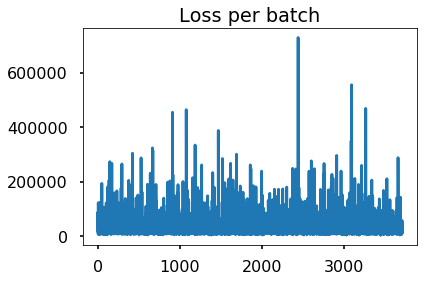

In [38]:
train_network(n_timesteps=100, batch=256, parallel =False, limit=0.5)

# Model performance and error evaluation on a different unseen test set

## Sample size = 200,000

In [43]:
model = load_lstm()

data = pd.read_csv('data/atlas_rucio-events-2017.07.06.csv')
data = data[:200000]
data = preprocess_data(data)
indices = data.index
durations = data['duration']
data = data.drop(['duration'], axis=1)
data = data[['bytes', 'delay', 'activity', 'dst-rse', 'dst-type',
             'protocol', 'src-rse', 'src-type', 'transfer-endpoint']]
data, durations = rescale_data(data, durations)
data = data.as_matrix()
durations = durations.as_matrix()
data, durations = prepare_model_inputs(data, durations, num_timesteps=100)

print('DONE')

Loaded model from disk
Model model compiled!!
using cached LabelEncoders for encoding data.....
200000 (200000,)
Total Data points for training/testing : 199901 of 100 timesteps each.
(199901, 100, 9) (199901,)
DONE


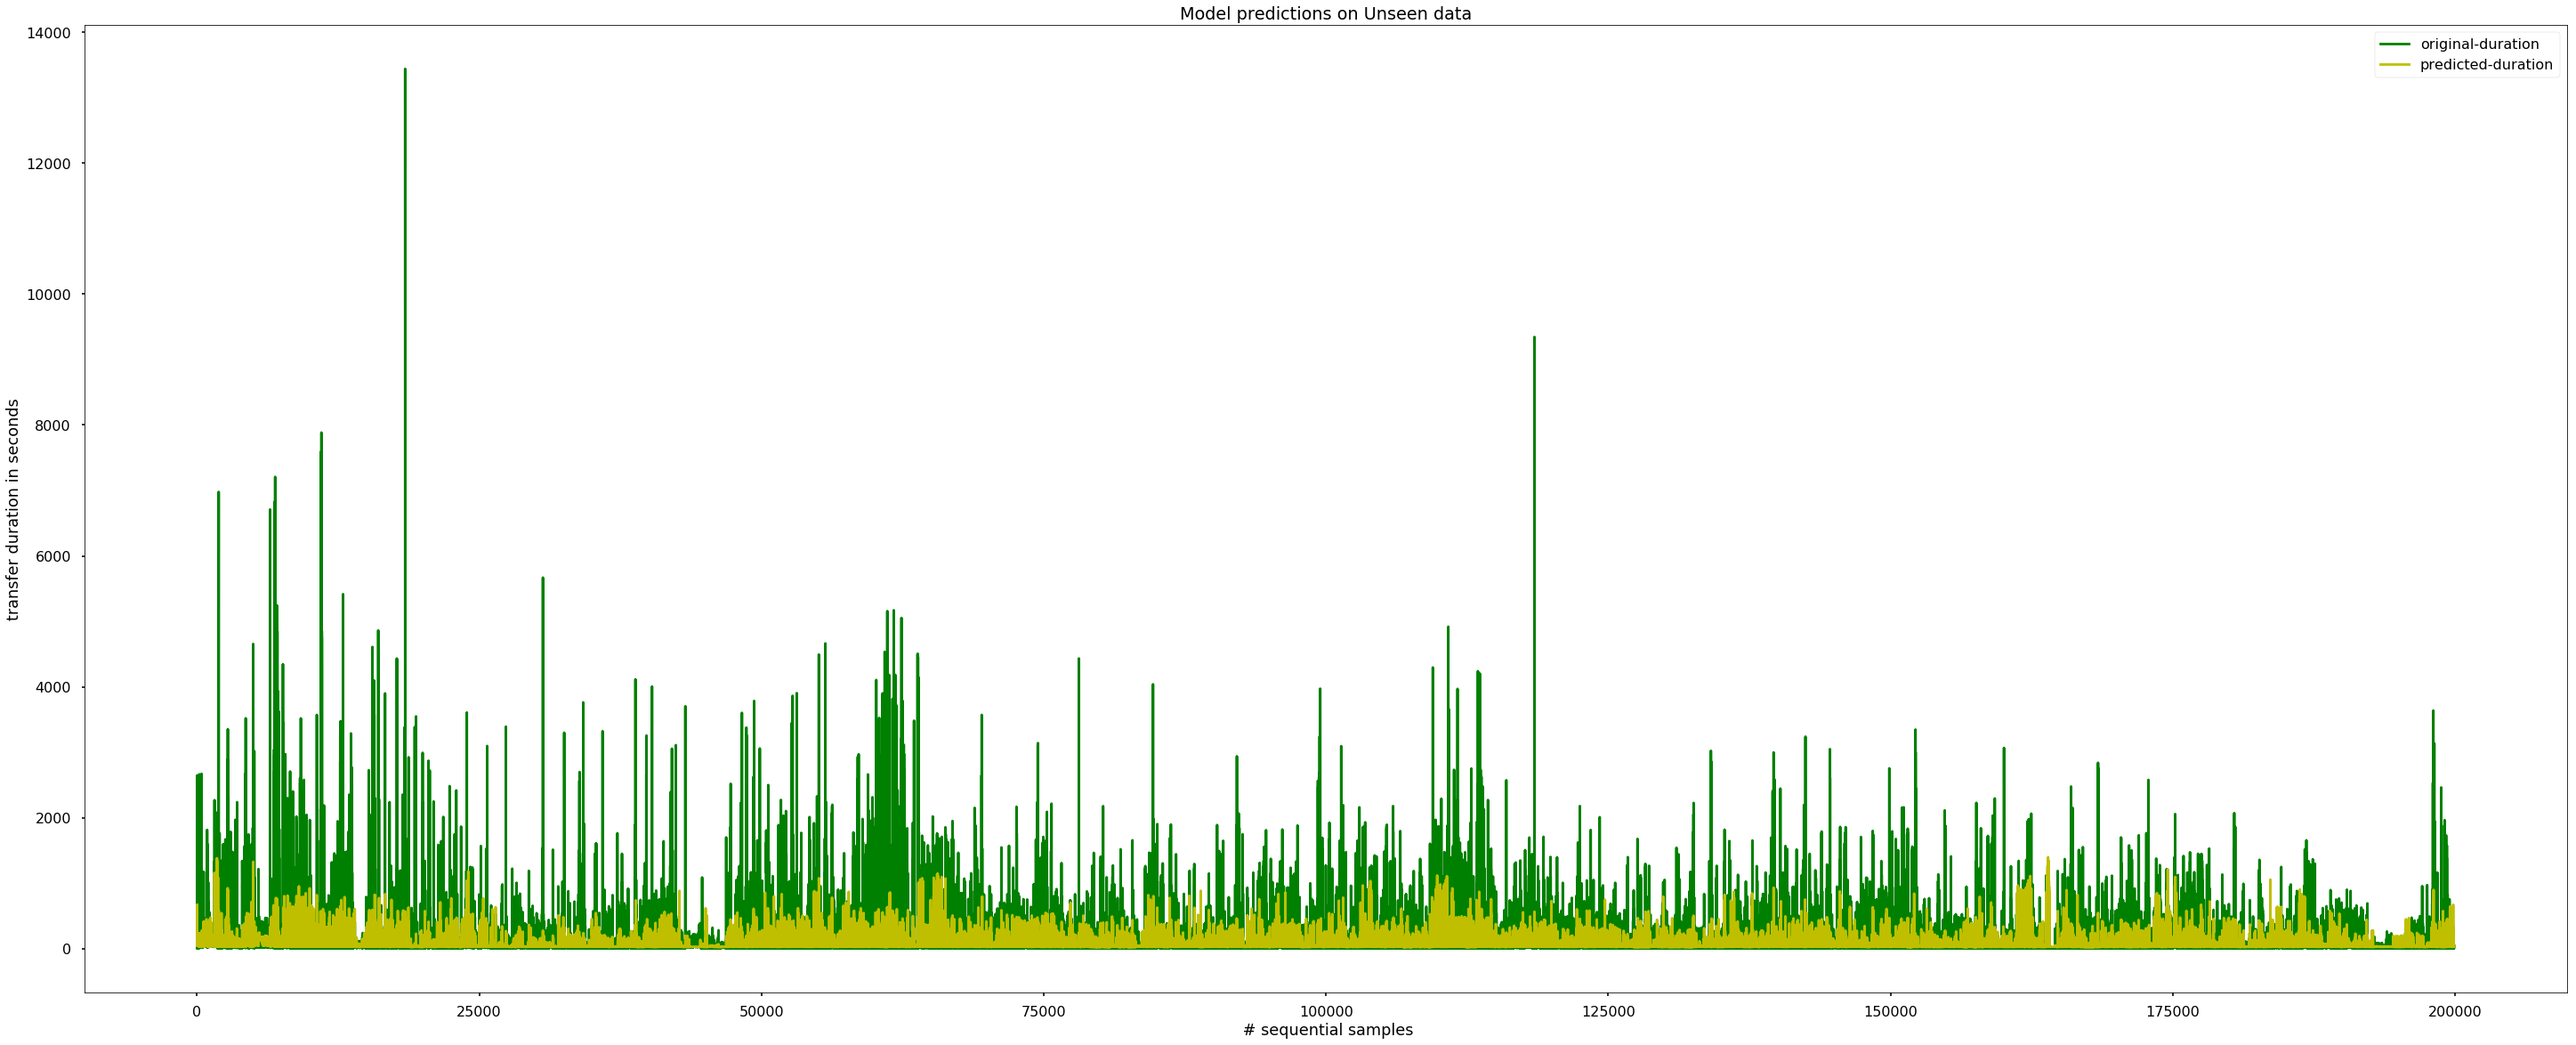

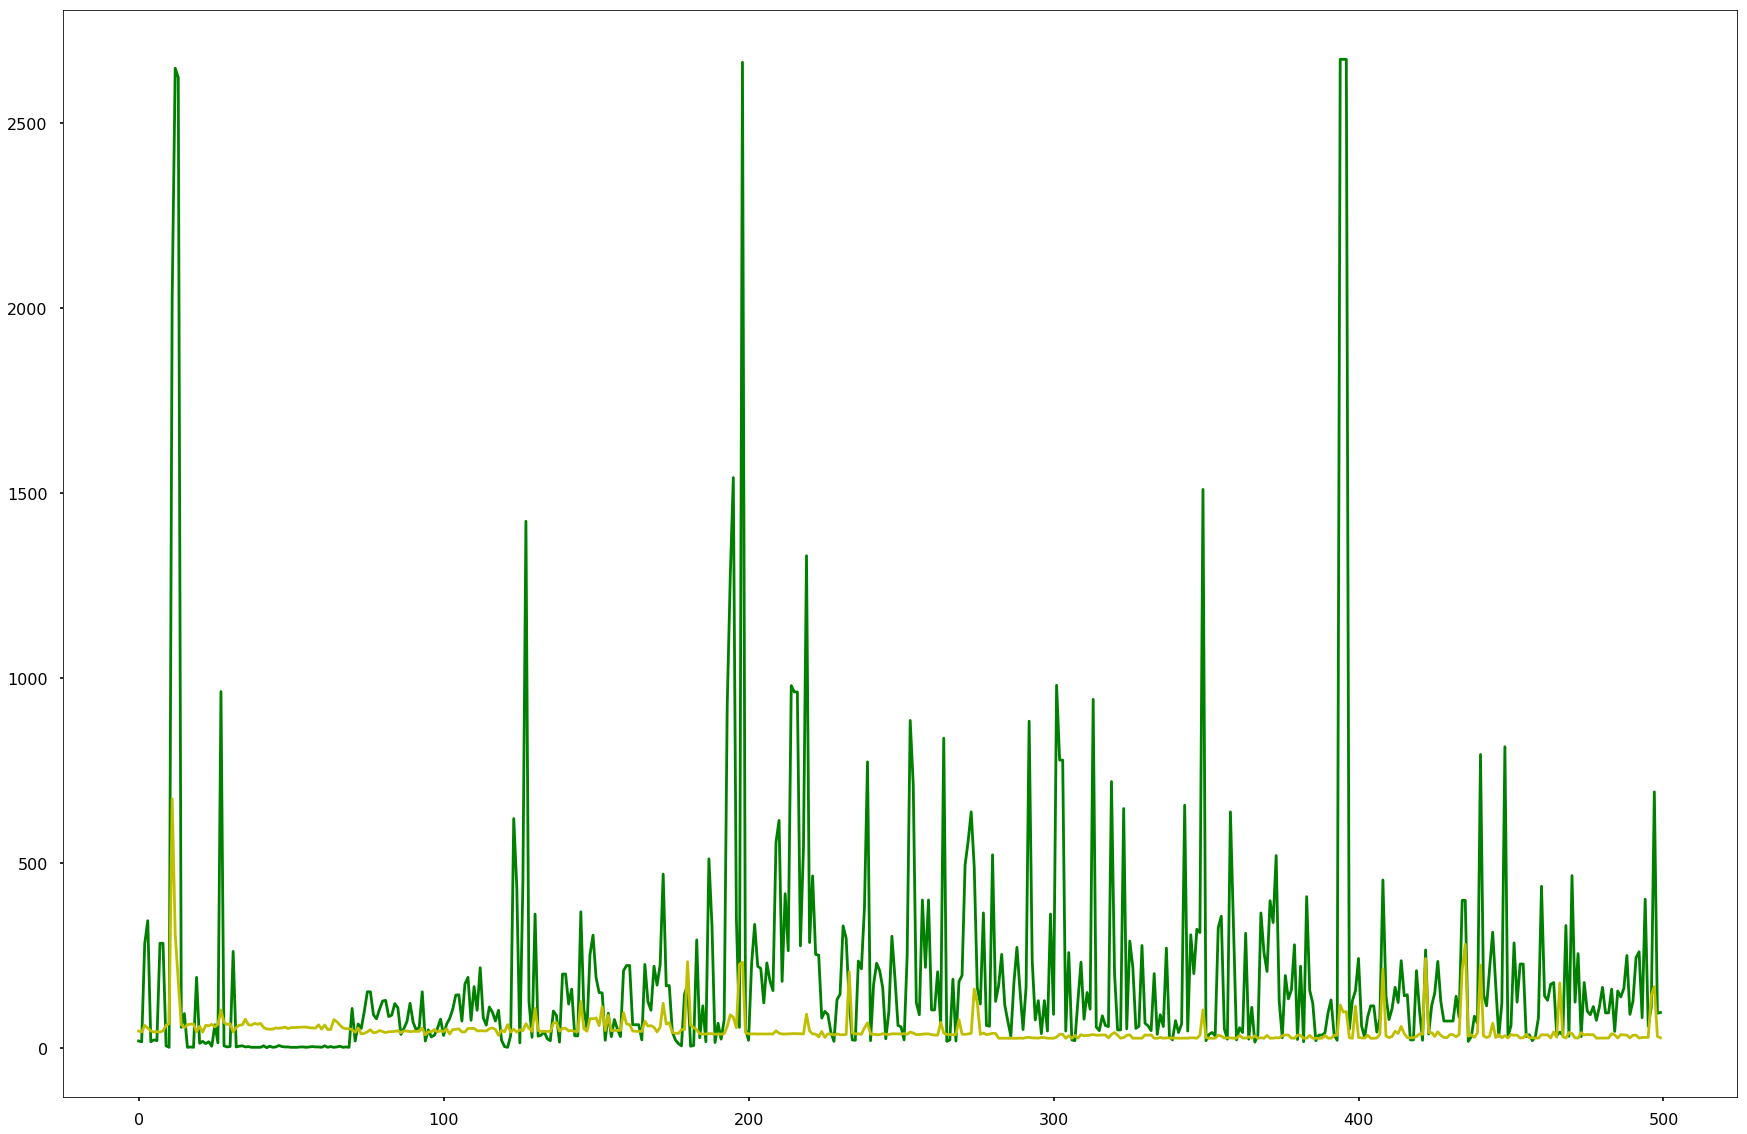

In [67]:
# pred = model.predict(data)

%matplotlib inline
import seaborn as sns

sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(durations, 'g', label='original-duration')
plt.plot(pred, 'y', label='predicted-duration')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.show()

plt.figure(figsize=(30,20))
plt.plot(durations[:500], 'g', label='original-duration')
plt.plot(pred[:500], 'y', label='predicted-duration')
plt.show()

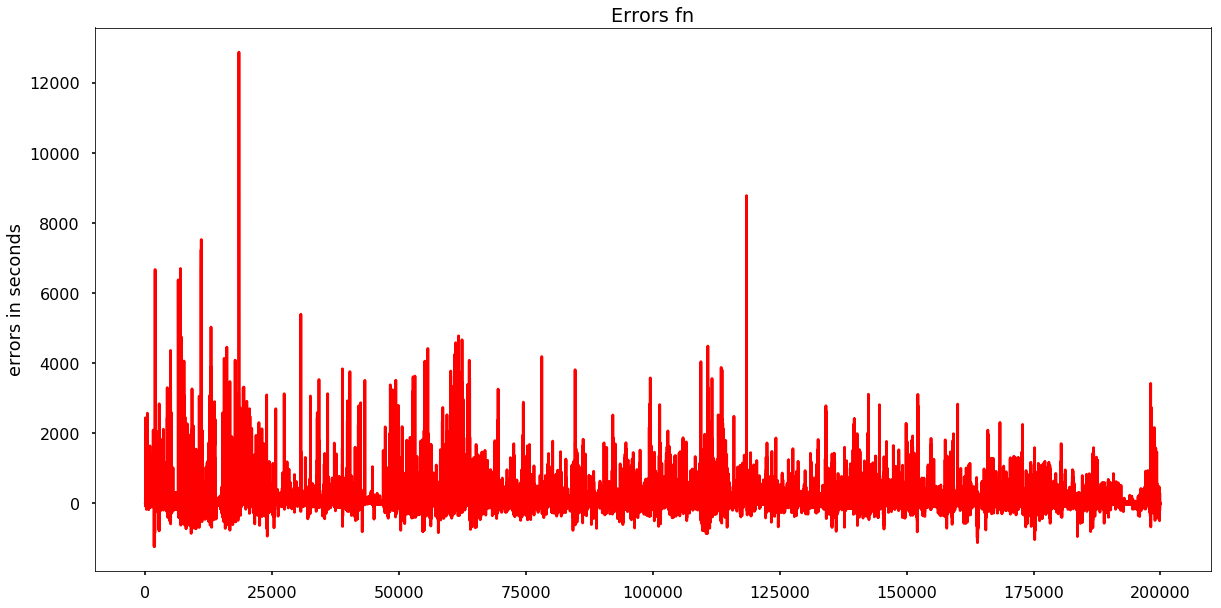

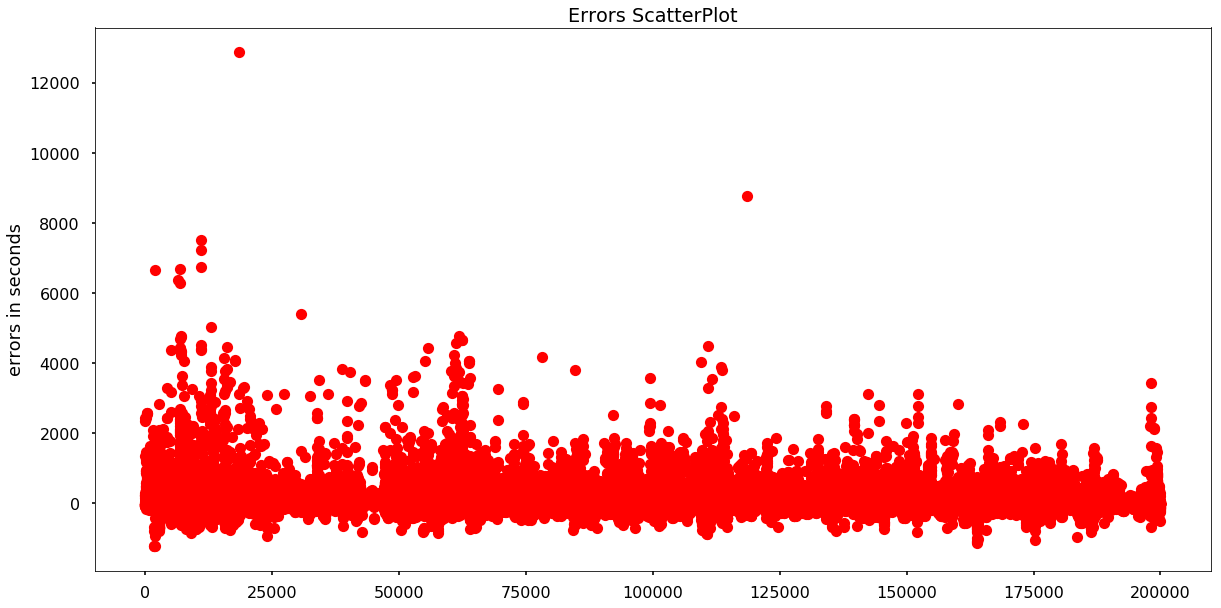

Maximum error value: 214.543692017
Total points with errors less than 3 minutes:187991 , percetage=93.99549999999999
Total points with errors less than 5 minutes:193667 , percetage=96.8335
Total points with errors less than 8 minutes:196408 , percetage=98.20400000000001
Total points with errors less than 10 minutes:197320 , percetage=98.66
Total points with errors less than 12 minutes:197907 , percetage=98.9535
Total points with errors less than 15 minutes:198503 , percetage=99.25150000000001
Total points with errors less than 20 minutes:199040 , percetage=99.52


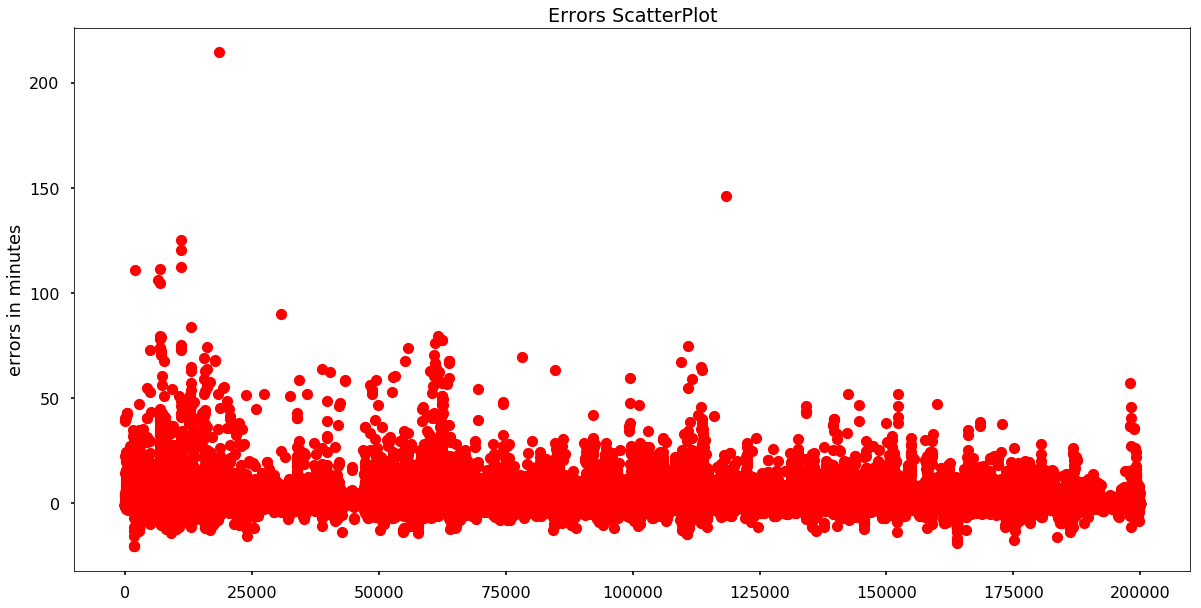

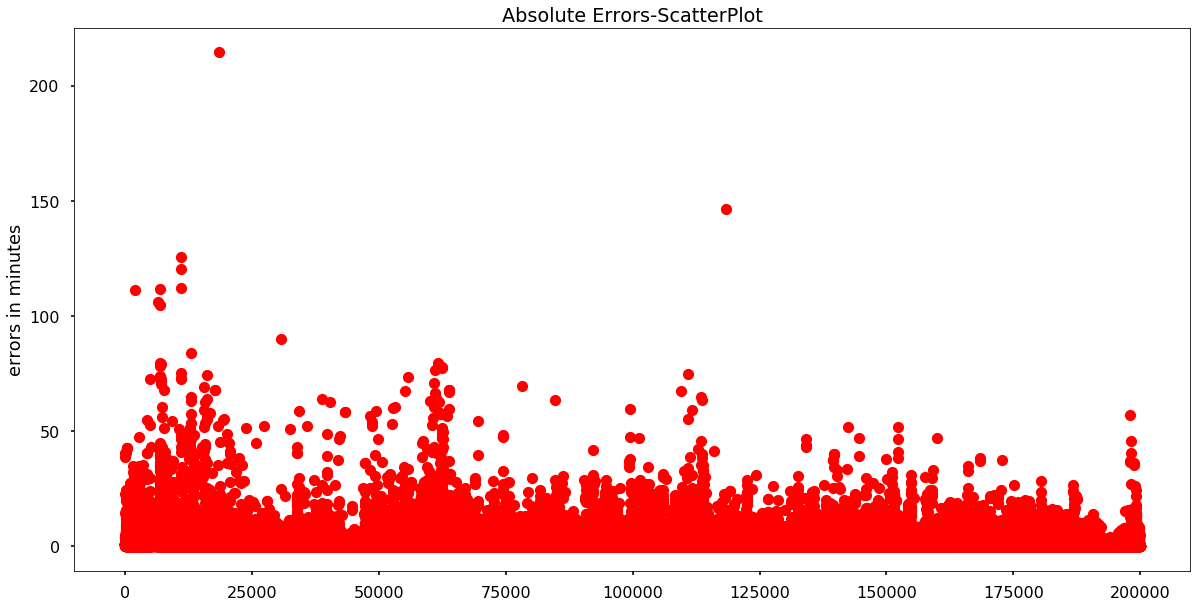

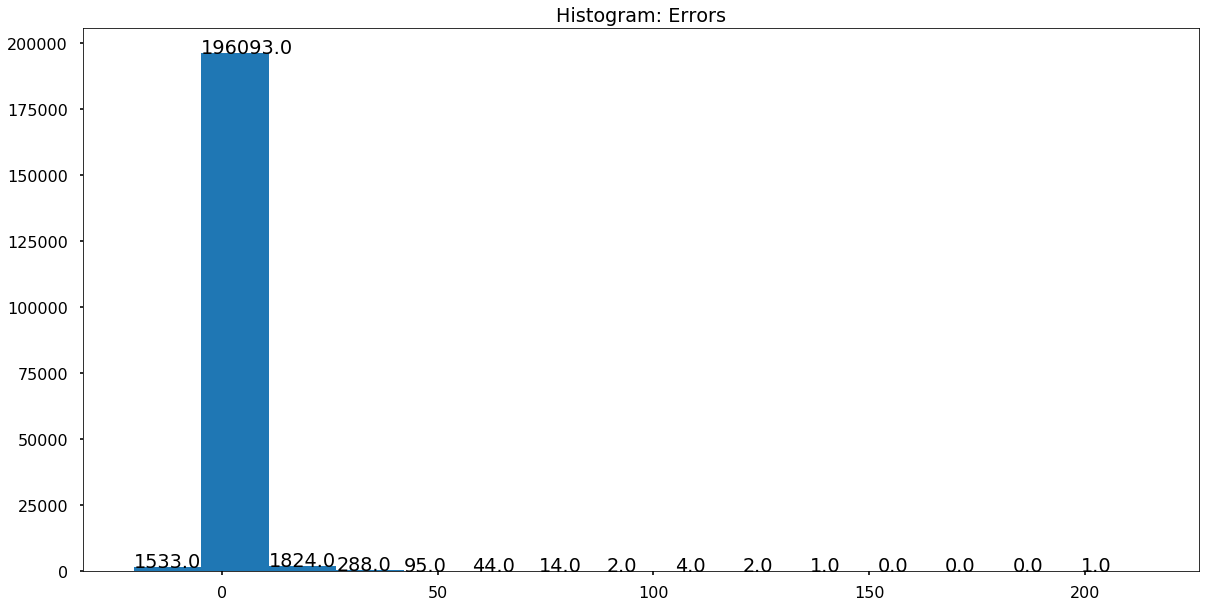

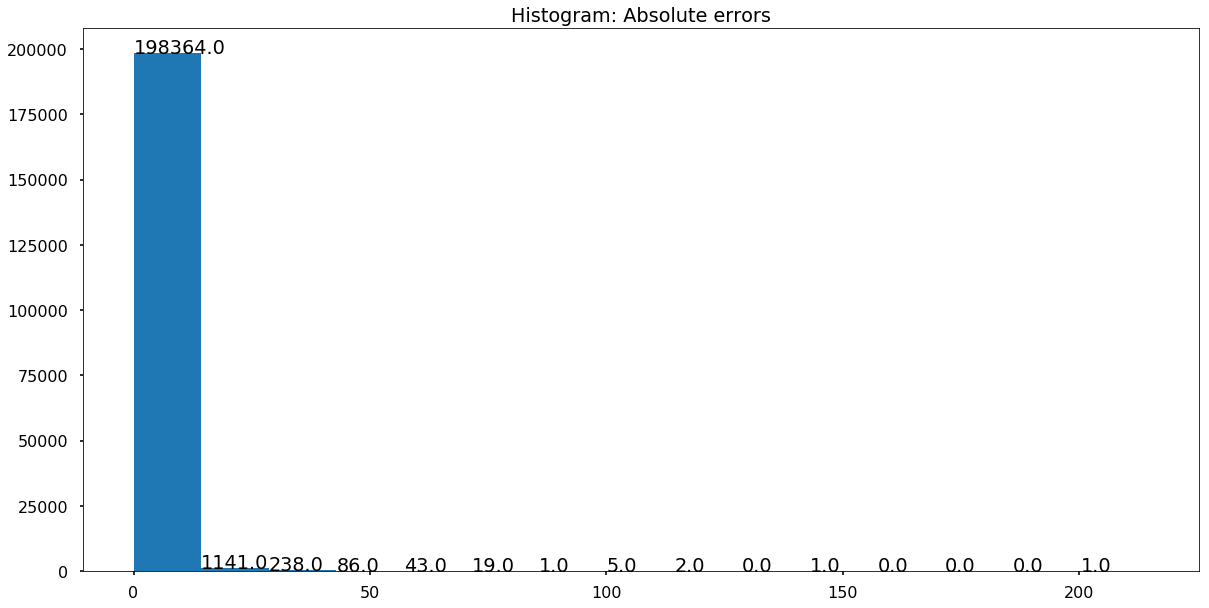

In [81]:
sns.set_context('poster')
plt.figure(figsize=(20,10))
durations = np.reshape(durations, (durations.shape[0],1))
errors = durations - pred
plt.plot(errors, 'r')
plt.title('Errors fn')
plt.ylabel('errors in seconds')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(errors, 'ro')
plt.title('Errors ScatterPlot')
plt.ylabel('errors in seconds')
plt.show()

errs = errors/60

print('Maximum error value:',np.max(errs))
j=0
k=0
l=0
m=0
n=0
o=0
p=0
for err in errs:
    if err<=3:
        j+=1
    if err<=5:
        k+=1
    if err<=8:
        l+=1
    if err<=10:
        m+=1
    if err<=12:
        n+=1
    if err<=15:
        o+=1
    if err<=20:
        p+=1

print('Total points with errors less than 3 minutes:{} , percetage={}'.format(j, 100*(j/200000)))
print('Total points with errors less than 5 minutes:{} , percetage={}'.format(k, 100*(k/200000)))
print('Total points with errors less than 8 minutes:{} , percetage={}'.format(l, 100*(l/200000)))
print('Total points with errors less than 10 minutes:{} , percetage={}'.format(m, 100*(m/200000)))
print('Total points with errors less than 12 minutes:{} , percetage={}'.format(n, 100*(n/200000)))
print('Total points with errors less than 15 minutes:{} , percetage={}'.format(o, 100*(o/200000)))
print('Total points with errors less than 20 minutes:{} , percetage={}'.format(p, 100*(p/200000)))
    

# durations = np.reshape(durations, (durations.shape[0],1))
# errors = durations - pred
plt.figure(figsize=(20,10))
plt.plot(errs, 'ro')
plt.title('Errors ScatterPlot')
plt.ylabel('errors in minutes')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(np.absolute(errs), 'ro')
plt.title('Absolute Errors-ScatterPlot')
plt.ylabel('errors in minutes')
plt.show()

# bins=[-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60]
plt.figure(figsize=(20,10))
arr= plt.hist(errs, bins=15)
plt.title('Histogram: Errors')
for i in range(15):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

plt.figure(figsize=(20,10))
arr2 = plt.hist(np.absolute(errs), bins=15)
plt.title('Histogram: Absolute errors')
for i in range(15):
    plt.text(arr2[1][i],arr2[0][i],str(arr2[0][i]))
plt.show()

In [66]:
score = model.evaluate(data, durations, verbose=0)
print('MSE = {} ; RMSE = {}'.format(score, np.sqrt(score)))

MSE = 36666.81610338218 ; RMSE = 191.4858117547673


In [18]:
def load_lstm():
    json_file = open('models/lstm_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("models/lstm_model.h5")
    print("Loaded model from disk")
    loaded_model.compile(loss="mse", optimizer="adam")
    print('Model model compiled!!')
    return loaded_model

def evaluate_network(limit=None, n_timesteps=100, path="data/",model=None):
    
    print('\n Locating training data files...')
    a= get_rucio_files(path=path)
    

    for i,file in enumerate(a):
        print("Training on file :{}".format(file))
        x, y, indices = load_rucio_data(file, limit=limit)
        print('\n Data Loaded and preprocessed !!....')
        x, y = prepare_model_inputs(x, y, num_timesteps=n_timesteps)
        print('Data ready for Evaluation')
        
        with tf.device('/gpu:0'):
            start_time = time.time()
            print('making predictions...')
            model = load_lstm()
            predictions = model.predict(x)
            end = time.time - start_time
            print('Done !! in {} min'.format(end/60))
            print('plotting graphs')

            plt.plot(y, 'g')
            plt.plot(predictions, 'y')
            plt.show()

            data = return_to_original(x, y, predictions, index=indices)
            plt.plot(data['duration'], 'g')
            plt.plot(data['prediction'], 'y')
            plt.title('Network predictions')
            plt.ylabel('durations in seconds')
            plt.show()

            data['mae'] = data['duration'] - data['prediction']
            data['mae'].plot()
            plt.show()

In [13]:
train_network(path='data/', limit=0.6, )
# evaluate_network(path='data/', limit = 50000)

In [14]:
# a= get_rucio_files(path=path)
# x, y, indices = load_rucio_data(a[2], limit=1000)
# print('\n Data Loaded and preprocessed !!....')
# x, y = prepare_model_inputs(x, y, num_timesteps=100)
# with tf.device('/gpu:0'):
#     model = load_lstm()
#     pred= model.predict(x)
#     print('done')


In [15]:
# plt.plot(pred)